In [1]:
import jax
import chex
import einops
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from typing import Callable
from functools import partial
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16
sns.set_palette("hls", 6)

In [4]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [5]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [6]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [7]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO", "HD"]

In [8]:
datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

In [9]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

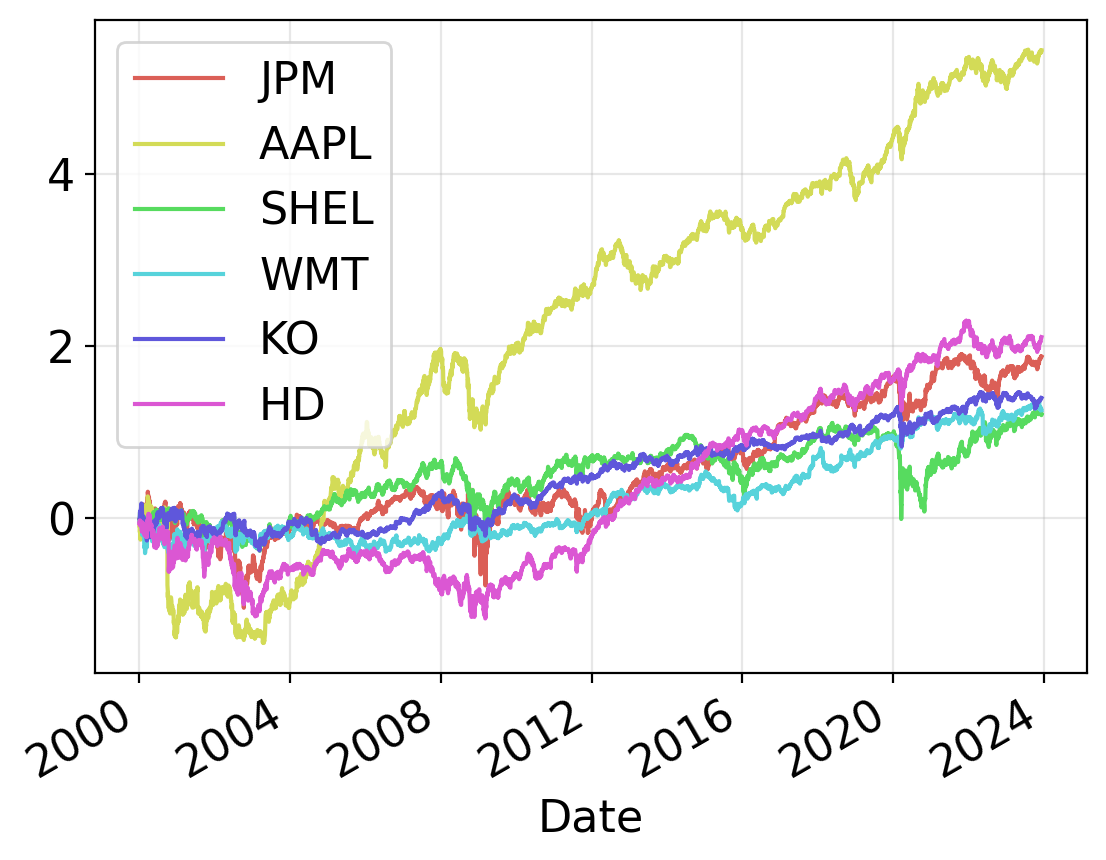

In [18]:
datasets_logr = pd.DataFrame(np.array(returns), index=datasets.index[1:], columns=assets)
index_date = datasets_logr.index
(datasets_logr.cumsum()).plot()
plt.grid(alpha=0.3)
plt.savefig("../figures/bandits-log-cumreturn.pdf")

# Stationary $\epsilon$-greedy bandit

In [99]:
import jfin

def store_reward(state, action, reward):
    return reward

In [100]:
key = jax.random.PRNGKey(3141)
agent = jfin.EpsilonGreedyAgent(epsilon=0.5)
state_final, returns_bandit = agent.init_and_run(key, returns, store_reward)

In [101]:
sr_ann = returns_bandit.mean() / returns_bandit.std() * jnp.sqrt(252)
sr_ann

Array(0.6843143, dtype=float32)

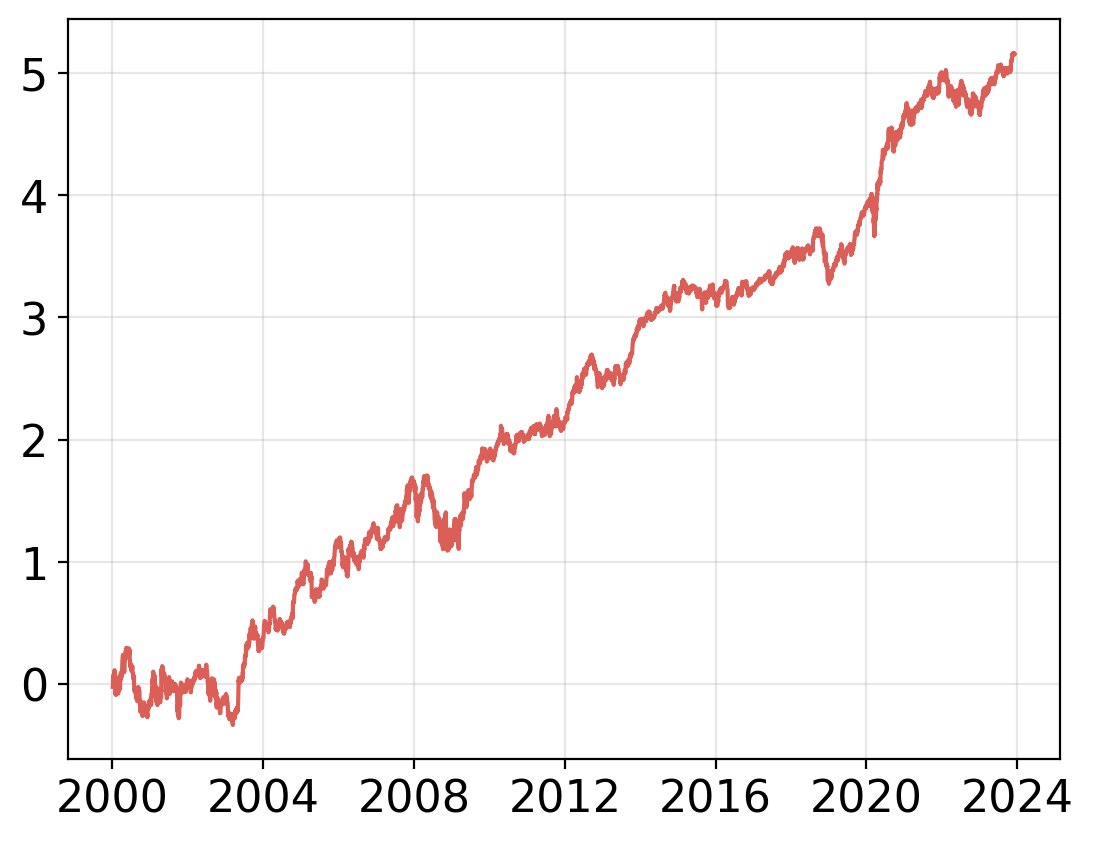

In [102]:
plt.plot(index_date, returns_bandit.cumsum())
plt.grid(alpha=0.3)

## Multiple simulations

Is this a winning strategy?

In [103]:
n_sims = 50
state_final, returns_bandit = agent.init_and_run_sims(key, returns, store_reward, n_sims)
returns_bandit.shape

(50, 6021)

In [104]:
sr_ann = returns_bandit.mean(axis=-1) / returns_bandit.std(axis=-1) * jnp.sqrt(252)
jnp.percentile(sr_ann, 50)

Array(0.25213557, dtype=float32)

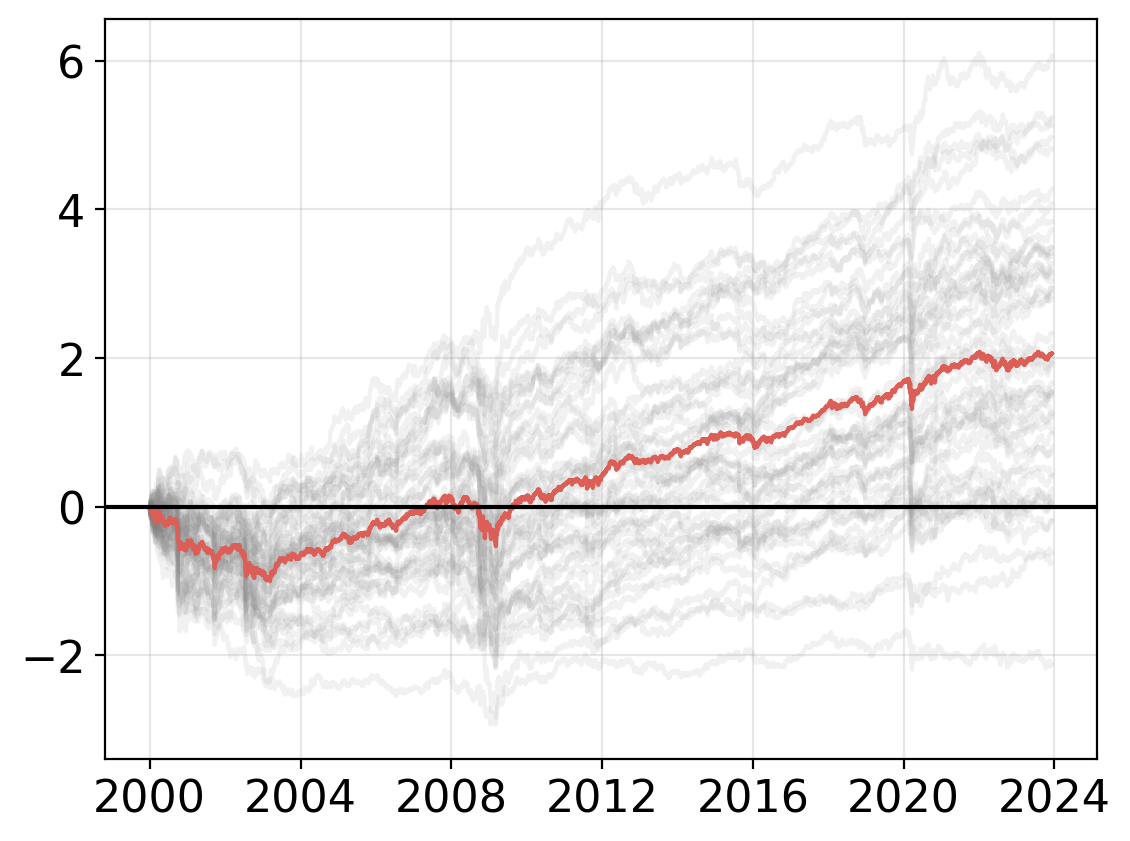

In [105]:
pnl_sims = np.array(returns_bandit.cumsum(axis=-1))
plt.plot(index_date, pnl_sims.T, alpha=0.1, c="tab:gray");
plt.plot(index_date, pnl_sims.mean(axis=0))
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## Evaluating over multiple $\epsilon$ values

In [46]:
@partial(jax.vmap, in_axes=(0, 0, None, None))
def eval_epsilon(key, epsilon, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon
    }
    
    return res

In [66]:
%%time
n_sims = 100
n_epsilon_values = 25
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon(keys_epsilon, epsilon_values, returns, n_sims)
res = jax.tree_map(np.array, res)

CPU times: user 2.39 s, sys: 39.3 ms, total: 2.43 s
Wall time: 10.9 s


### Sharpe ratio

In [67]:
returns_sr = pd.DataFrame(res["sr_ann"], index=epsilon_values).T

returns_sr_mean = returns_sr.mean()
returns_sr_mean.name = "mean_sr"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_sr_mean.reset_index().sort_values("mean_sr", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

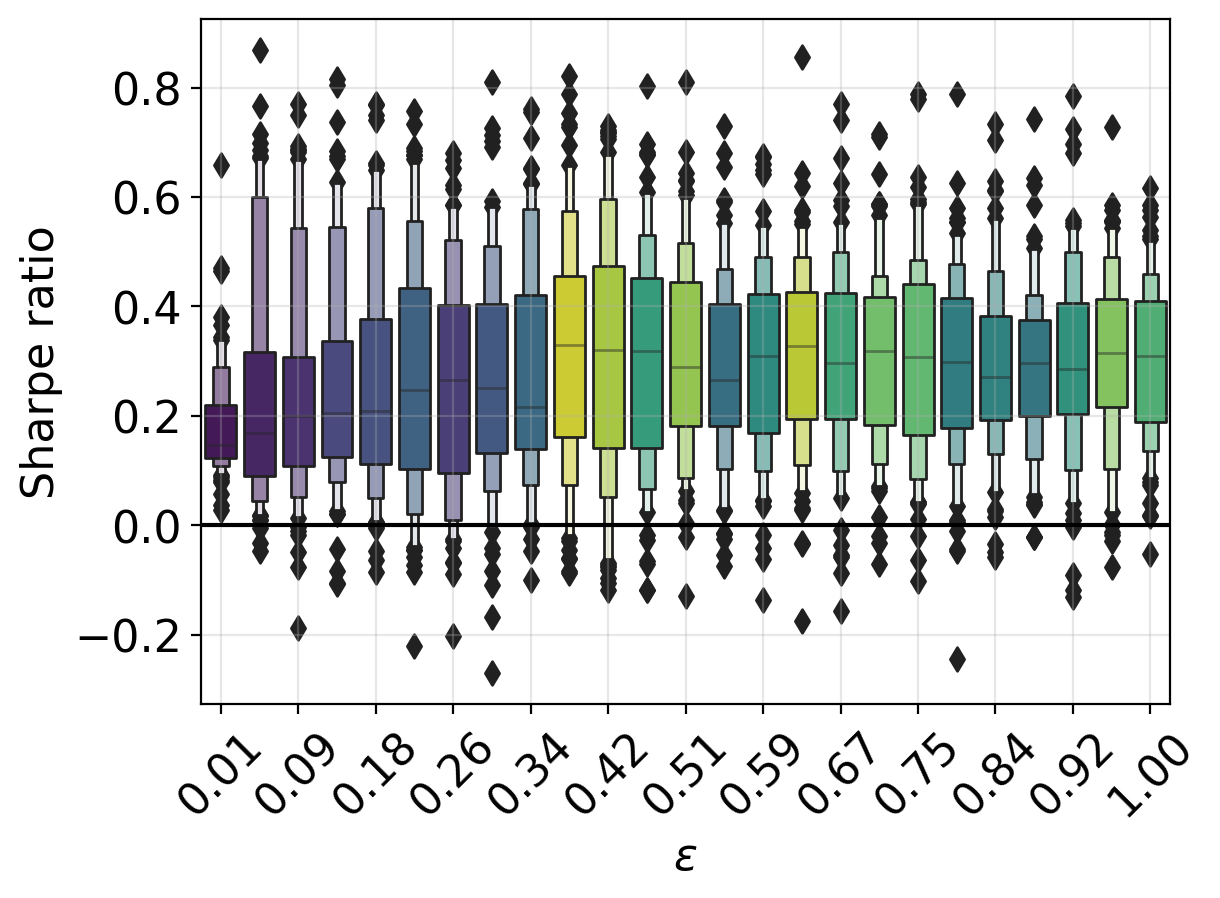

In [68]:
sns.boxenplot(
    x="variable",
    y="value",
    data=returns_sr.melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Sharpe ratio")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

### PnL

In [77]:
returns_pnl = pd.DataFrame(res["pnl"], index=epsilon_values).T

returns_pnl_mean = returns_pnl.mean()
returns_pnl_mean.name = "pnl"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_pnl_mean.reset_index().sort_values("pnl", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

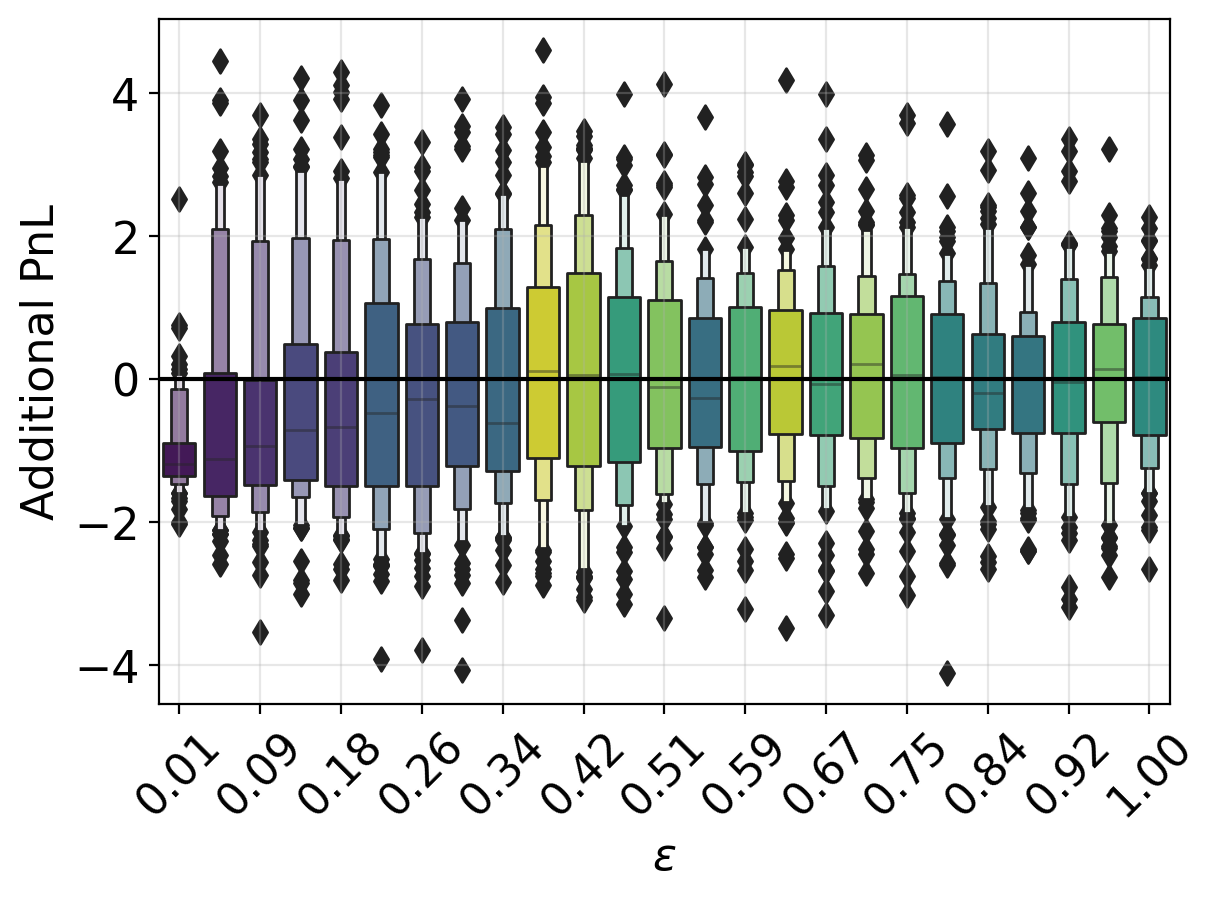

In [98]:
sns.boxenplot(
    x="variable",
    y="value",
    data=(returns_pnl - returns_pnl[1].mean()).melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Additional PnL")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

# non-stationary $\epsilon$-greedy

## Evaluating over multiple $\epsilon$ values

In [109]:
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def eval_epsilon(key, epsilon, alpha, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon
    }
    
    return res

In [ ]:
%%time
n_sims = 100
n_epsilon_values = 25
alpha = 0.4
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon(keys_epsilon, epsilon_values, alpha, returns, n_sims)
res = jax.tree_map(np.array, res)

---

# Old stuff

In [34]:
n_bandits = len(assets)
count_v = jnp.zeros(n_bandits)
value_v = jnp.zeros(n_bandits)

In [35]:
@chex.dataclass
class BanditState:
    count: jax.Array
    value: jax.Array
    key: jax.random.PRNGKey
    
    def update(self, action, value, count):
        new_key = jax.random.split(self.key)[1]
        state = self.replace(
            value=self.value.at[action].set(value),
            count=self.count.at[action].set(count),
            key=new_key,
        )
        return state


def epsilon_step(
    state: BanditState,
    returns: chex.Array,
    epsilon: float,
    alpha: int,
    storefn: Callable
):
    """
    Epsilon-greedy step
    """
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon) # w.r.t. the value function
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]
    new_count = state.count[action] + 1
    
    discount = (1 / new_count) * (alpha == 0.0) + alpha
    new_value = state.value[action] + (reward - state.value[action]) * discount
    
    state = state.update(action, new_value, new_count)
    return state, storefn(state, action, reward)


def run_bandit(key, data, epsilon, alpha, storefn):
    _, n_arms = data.shape
    count_v = jnp.zeros(n_arms)
    value_v = jnp.zeros(n_arms)
    state = BanditState(count=count_v, value=value_v, key=key)
    
    partial_step = partial(epsilon_step, epsilon=epsilon, alpha=alpha, storefn=storefn)
    state, hist = jax.lax.scan(partial_step, state, data)
    return state, hist


@partial(jax.jit, static_argnames=("n_sims", "storefn"))
def run_bandit_sims(key, data, epsilon, alpha, n_sims, storefn):
    keys = jax.random.split(key, n_sims)
    
    vmap_returns = jax.vmap(run_bandit, in_axes=(0, None, None, None, None))
    _, hist = vmap_returns(keys, data, epsilon, alpha, storefn)
    return hist


@partial(jax.jit, static_argnames=("n_sims",))
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
def run_bandit_sims_eps(key, data, epsilon_v, alpha, n_sims):
    return run_bandit_sims(key, data, epsilon_v, alpha, n_sims, store_reward)

In [36]:

state = BanditState(count=count_v, value=value_v, key=key)
partial_step = partial(epsilon_step, epsilon=0.1, alpha=0.0, storefn=store_reward)
state_final, returns_bandit = jax.lax.scan(partial_step, state, returns)

In [37]:
key = jax.random.PRNGKey(3141)
agent = jfin.EpsilonGreedyAgent(epsilon=0.5, alpha=0.0)
agent.init_and_run(key, returns, store_reward)

(BanditState(count=Array([ 505., 3201.,  745.,  489.,  568.,  513.], dtype=float32), value=Array([5.6189246e-04, 1.1770956e-03, 5.2204373e-04, 1.1054615e-05,
        5.1504496e-04, 8.0586819e-04], dtype=float32), key=Array([3849314492,  794812994], dtype=uint32)),
 Array([-0.02218647,  0.00882014,  0.01085356, ...,  0.00153544,
        -0.00570329,  0.0023863 ], dtype=float32))

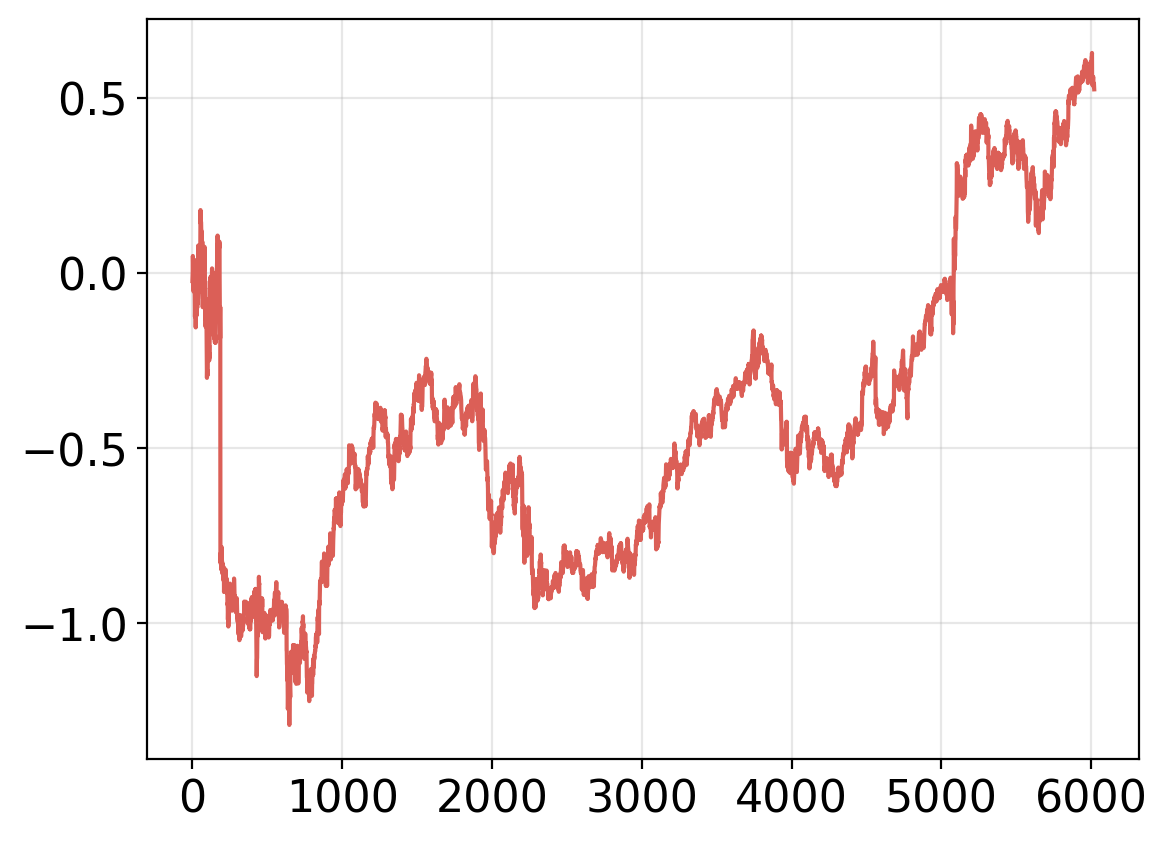

In [38]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [19]:
%%time
n_simulations = 100
n_epsilon_values = 25
epsilon_values = jnp.linspace(1e-7, 1, n_epsilon_values)

epsilon_greedy_returns = run_bandit_sims_eps(key, returns, epsilon_values, 0.0, n_simulations)

epsilon_greedy_returns = np.array(epsilon_greedy_returns)
epsilon_greedy_cumsum = epsilon_greedy_returns.cumsum(axis=-1)

CPU times: user 1.97 s, sys: 64.7 ms, total: 2.03 s
Wall time: 10.8 s


In [20]:
epsilon_greedy_final = epsilon_greedy_cumsum[..., -1]
epsilon_greedy_final = pd.DataFrame(
    epsilon_greedy_final, index=epsilon_values
).T

In [21]:
returns_mean = epsilon_greedy_returns[..., 252:].mean(axis=-1)
returns_std = epsilon_greedy_returns[..., 252:].std(axis=-1)
returns_sr = returns_mean / returns_std * jnp.sqrt(252)

returns_sr = pd.DataFrame(
    returns_sr,
    index=epsilon_values
).T

In [22]:
returns_sr_mean = returns_sr.mean()
returns_sr_mean.name = "mean_sr"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_sr_mean.reset_index().sort_values("mean_sr", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

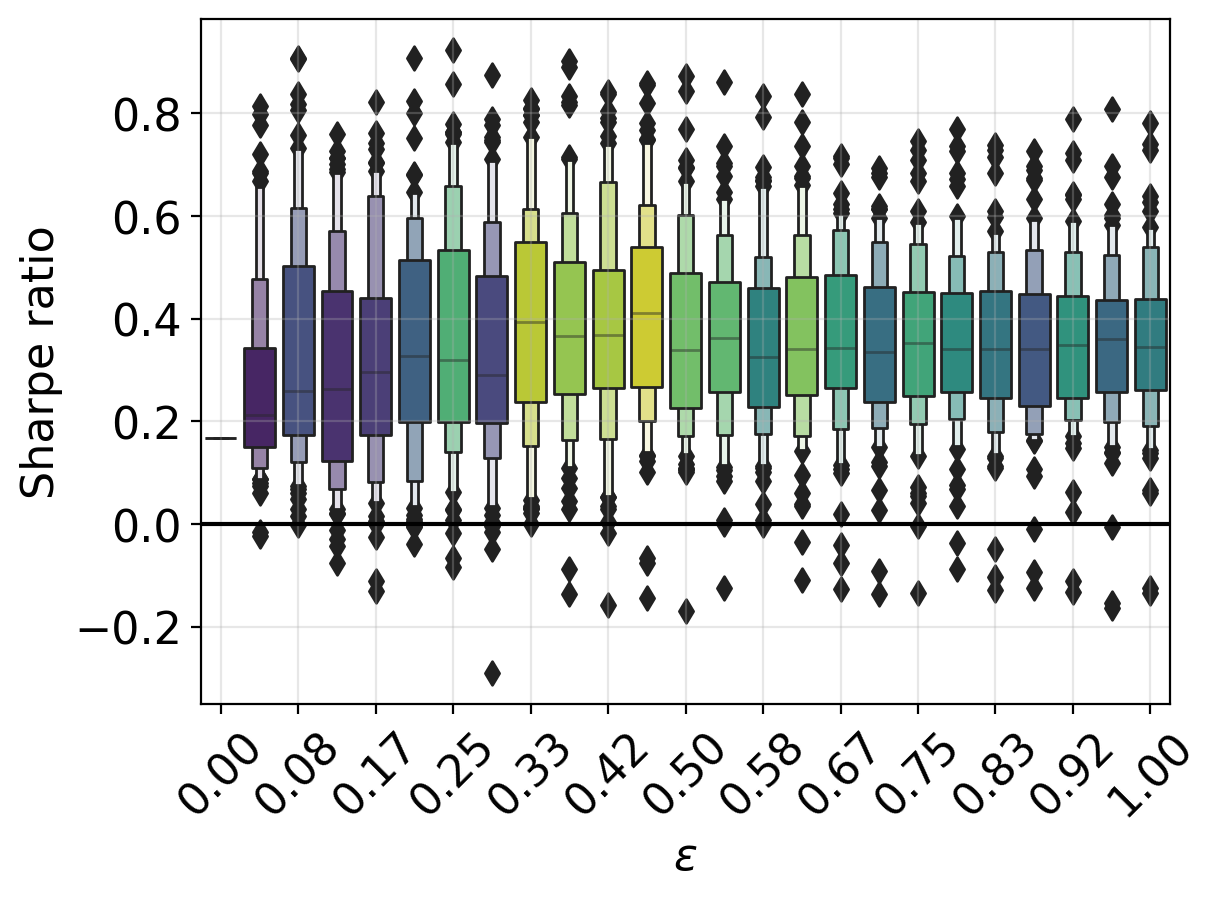

In [23]:
sns.boxenplot(
    x="variable",
    y="value",
    data=returns_sr.melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Sharpe ratio")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

In [24]:
median_value_final = epsilon_greedy_final.median(axis=0)
median_value_final.name = "median"

summary_final = epsilon_greedy_final.melt()
summary_final.tail()

,variable,value
2495,1.0,0.164026
2496,1.0,1.996666
2497,1.0,1.854041
2498,1.0,2.699900
2499,1.0,4.014477


In [25]:
palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = median_value_final.reset_index().sort_values("median", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

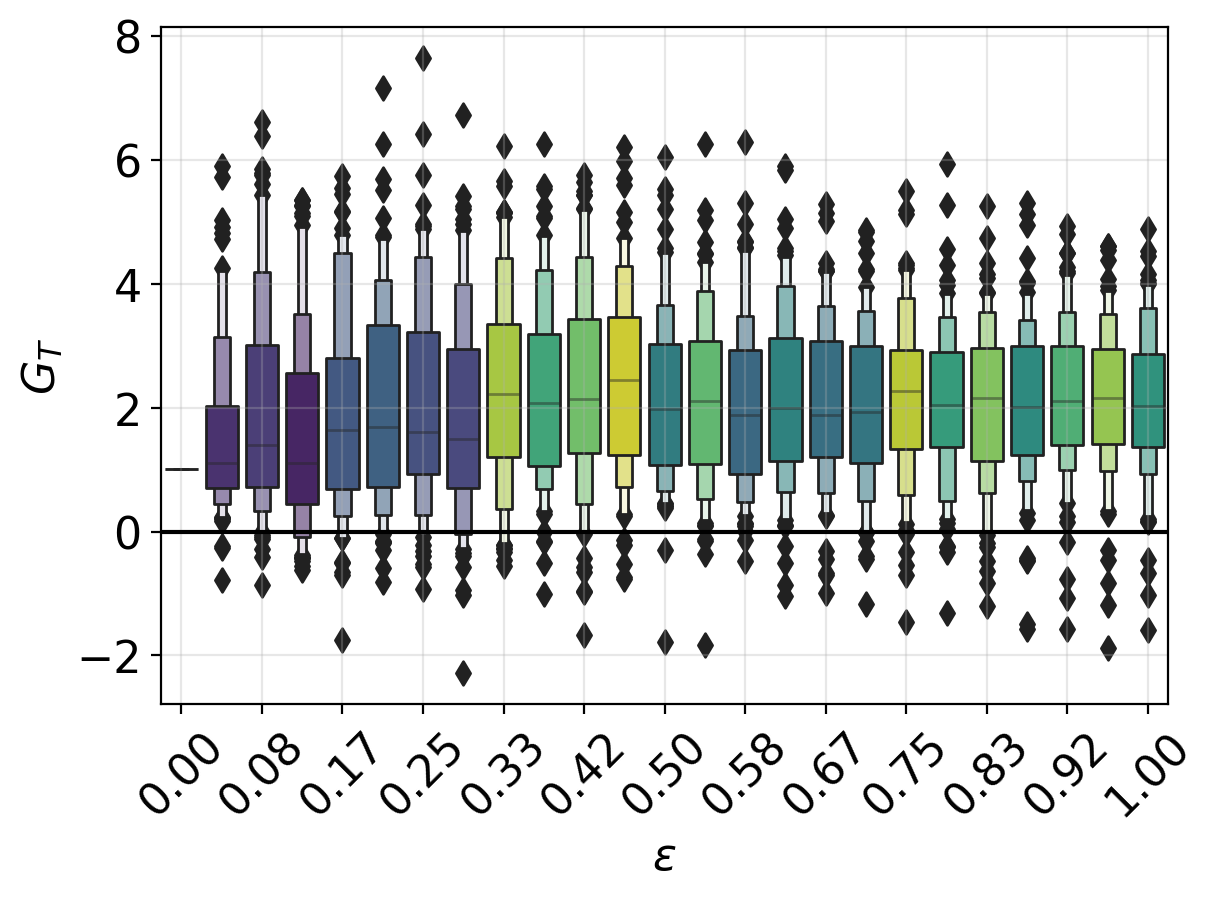

In [26]:
# NOTE: PRETTYFY with median_value_final

fig, ax = plt.subplots()
sns.boxenplot(
    y="value", x="variable", data=summary_final,
    palette=colors, linewidth=1, ax=ax,
)
plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("$G_T$")
plt.tight_layout()
plt.axhline(y=0, c="black")
plt.savefig("../figures/stationary-bandit-reward.pdf")

0.50000006


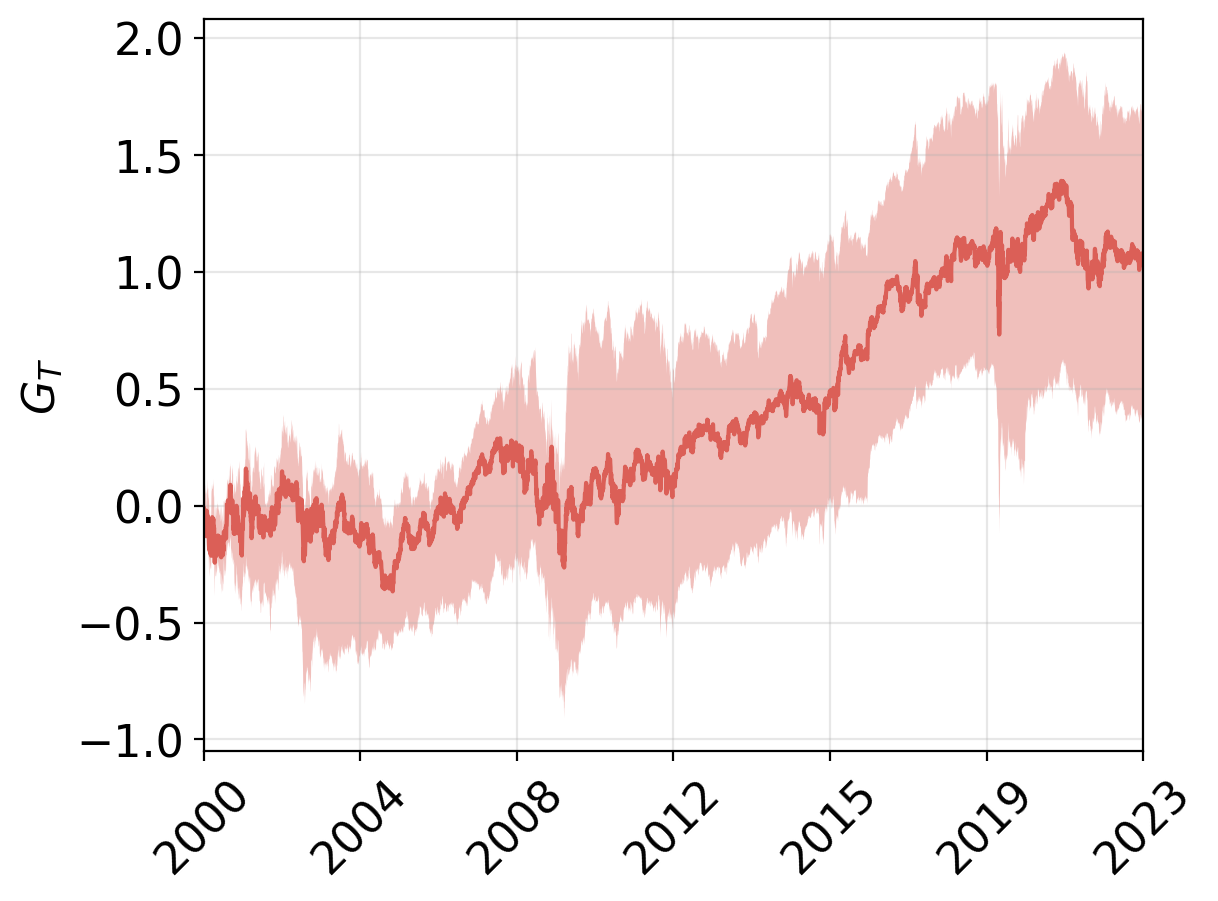

In [27]:
ix = 12
print(epsilon_values[ix])

vmid = np.percentile(epsilon_greedy_cumsum[:,ix], 50, axis=0)
lbound = np.percentile(epsilon_greedy_cumsum[:, ix], 10, axis=0)
ubound = np.percentile(epsilon_greedy_cumsum[:, ix], 90, axis=0)

plt.plot(vmid)

plt.fill_between(timesteps, lbound, ubound, alpha=0.4)
plt.grid(alpha=0.3)
vals, _ = plt.xticks()
ticks = vals / 6000 * 23 + 2000
plt.xticks(vals, ticks.round().astype(int), rotation=45)
plt.ylabel("$G_T$")
plt.xlim(0, 6000)
plt.tight_layout()
plt.savefig("../figures/cumulative-reward-stationary-epsilon-greedy.pdf")

## Non-stationary version

In [28]:
def store_all(state, action, reward):
    return state, action, reward

In [29]:
state_hist, action_hist, sims = run_bandit_sims(key, returns, alpha=0.5, epsilon=0.82, n_sims=50, storefn=store_all)
final_reward = sims.sum(axis=1)
final_reward

Array([ 1.2471352 ,  1.4394474 ,  3.4640398 ,  0.05898443,  0.7458523 ,
       -0.24333346,  1.7037604 ,  3.1701922 ,  2.2936423 ,  3.69277   ,
       -0.04159743,  1.8803817 ,  1.7203395 ,  3.8088083 ,  2.8291    ,
        1.0874009 ,  2.220511  ,  2.8219008 ,  2.2569418 ,  2.4851274 ,
        1.601415  ,  1.6029482 ,  2.3323197 ,  3.6985376 ,  2.08825   ,
        2.9144266 ,  3.8922403 ,  3.7096875 ,  0.9862386 ,  2.0782151 ,
        4.6009517 ,  4.119829  ,  1.5821836 ,  3.9475513 ,  3.6726542 ,
        2.1314297 ,  2.314139  ,  3.4770358 ,  3.3290496 ,  0.7888092 ,
        2.5388293 ,  1.5977193 ,  0.63006294,  2.8156884 ,  2.2050436 ,
        0.7966571 ,  5.6416845 ,  1.1034796 ,  2.208372  ,  0.44543102],      dtype=float32)

In [30]:
value_hist = state_hist.value

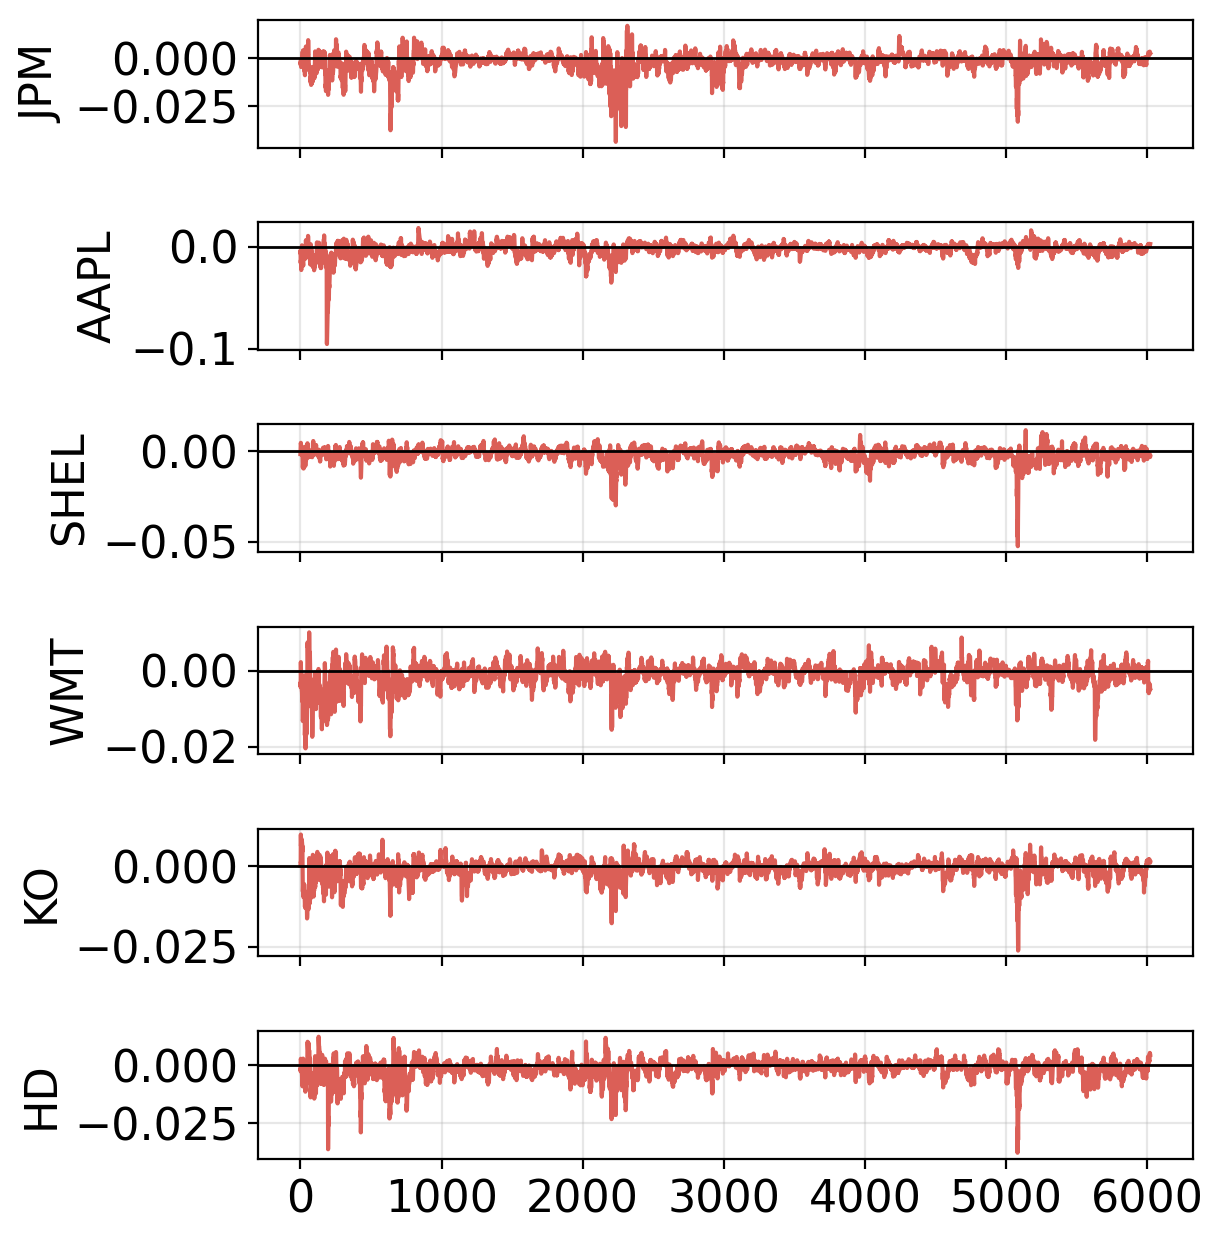

In [31]:
fig, ax = plt.subplots(len(assets), 1, figsize=(6.4, 6.5), sharex=True)
for i, axi in enumerate(ax):
    axi.plot(value_hist[..., i].mean(axis=0))
    axi.grid(alpha=0.3)
    axi.set_ylabel(assets[i])
    axi.axhline(y=0, c="black", linewidth=1)
plt.tight_layout()

In [32]:
np.bincount(np.percentile(action_hist, 50, axis=0).astype(int))

array([   0,  117, 3523, 2345,   36])

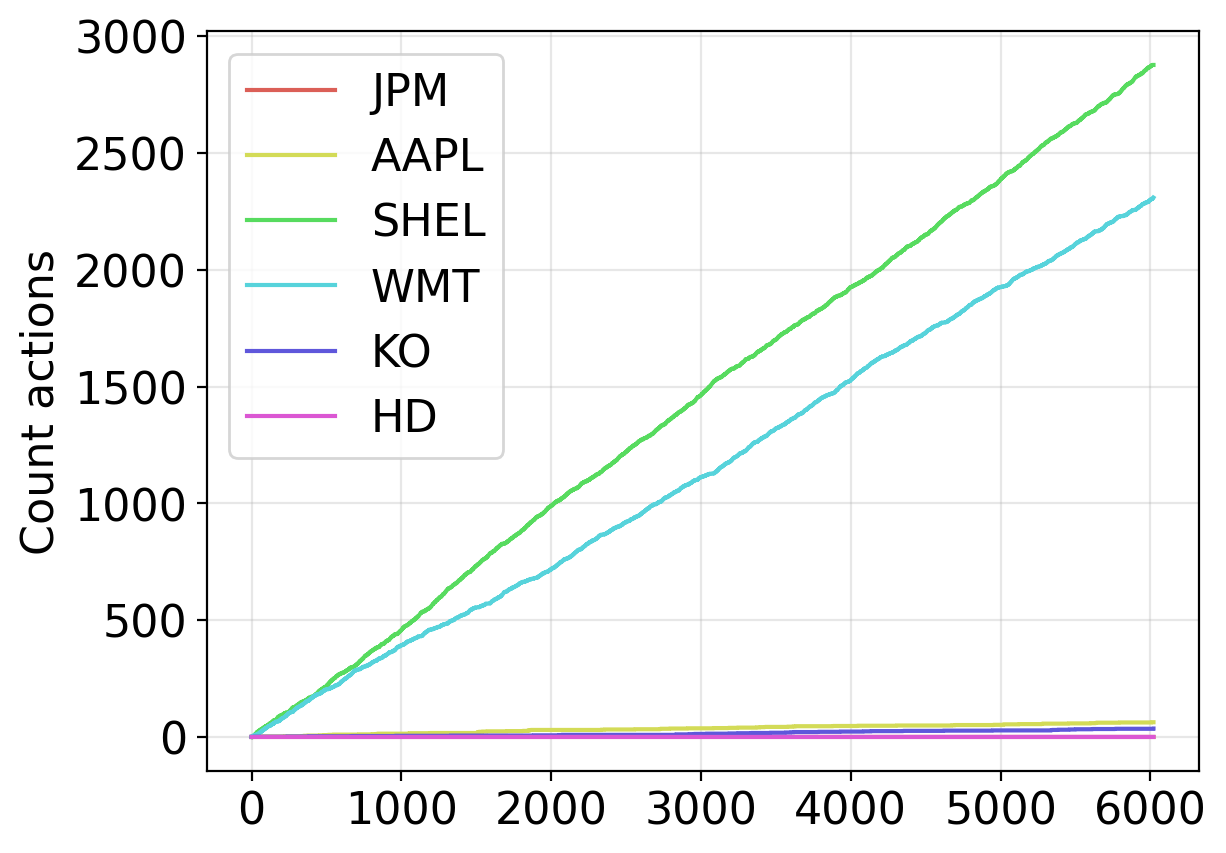

In [33]:
actions_sum = np.array(jax.nn.one_hot(jnp.percentile(action_hist, 50, axis=0), len(assets)))
plt.plot(actions_sum.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
# plt.yscale("log")
plt.grid(alpha=0.3)

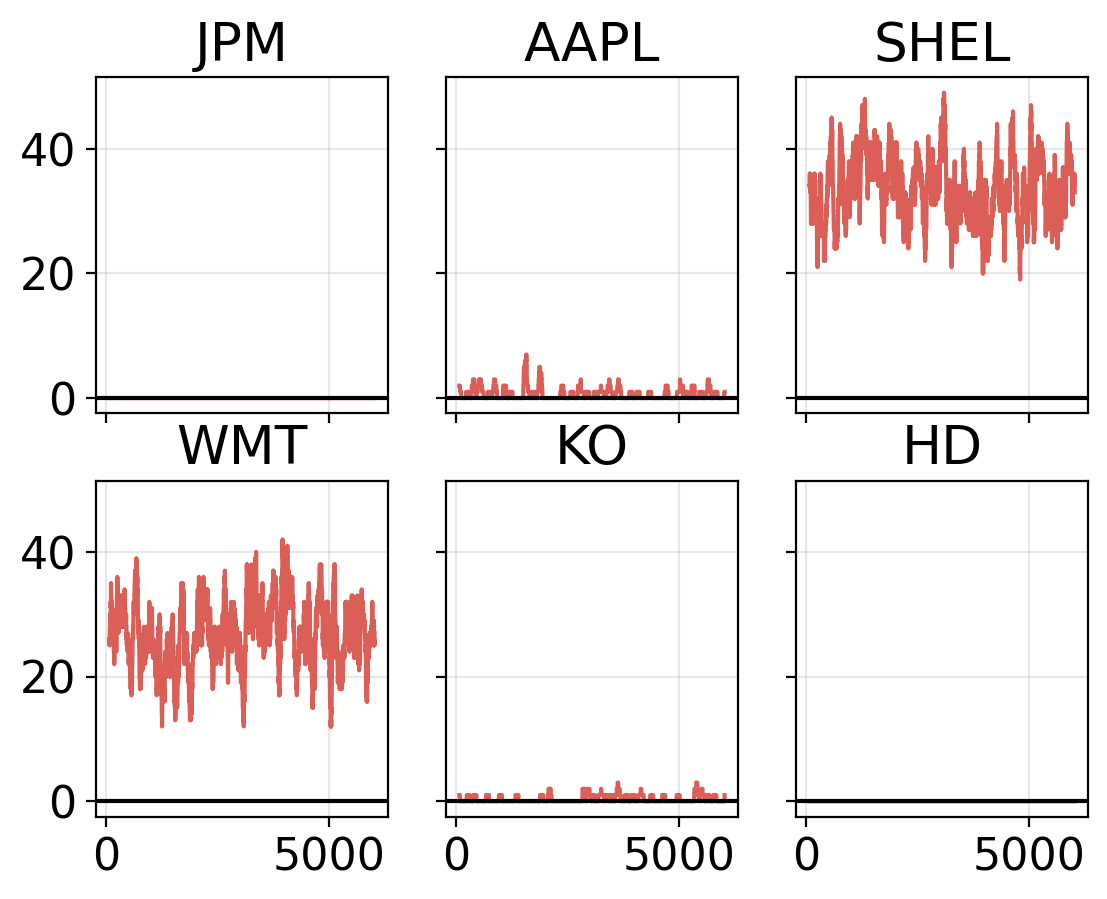

In [34]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax = ax.ravel()
v = pd.DataFrame(actions_sum).rolling(280 // 4).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)

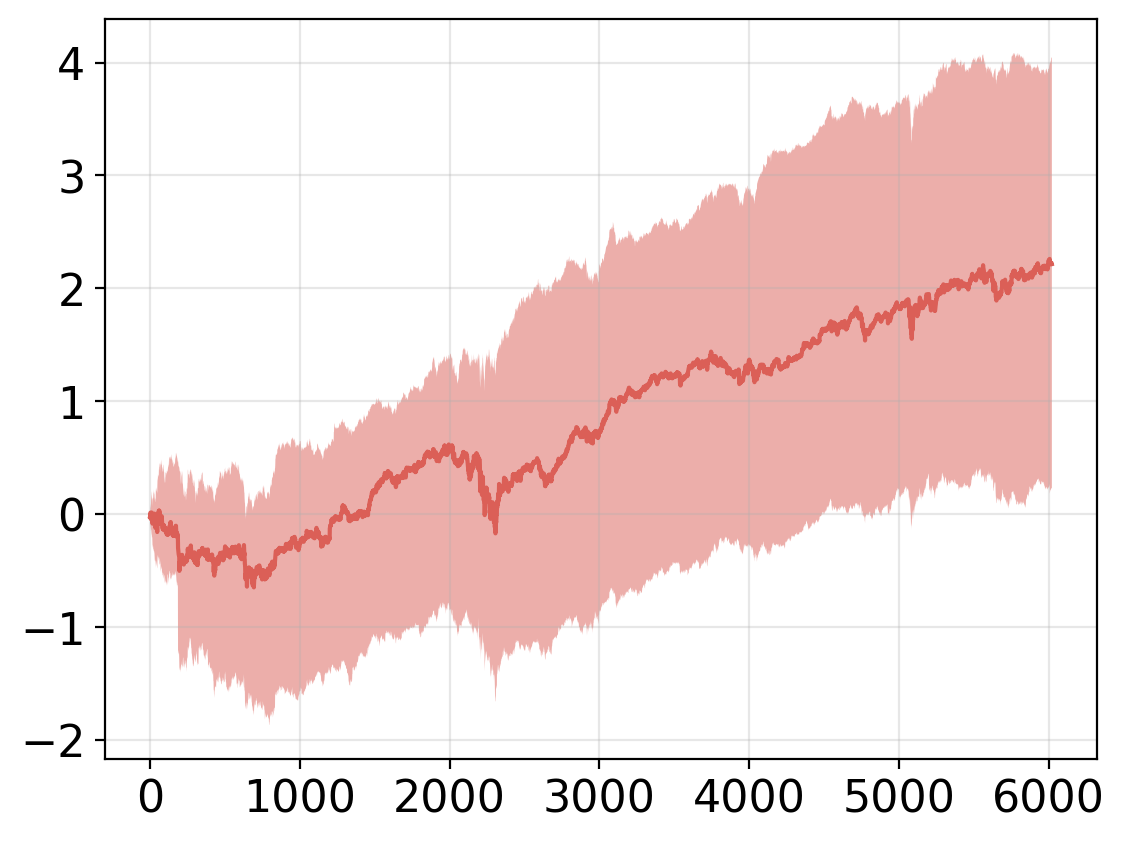

In [35]:
returns_cumsum = sims.cumsum(axis=1)
midval = jnp.percentile(returns_cumsum, q=50, axis=0)
lbound = jnp.percentile(returns_cumsum, q=5, axis=0)
ubound = jnp.percentile(returns_cumsum, q=95, axis=0)

plt.plot(midval)
plt.fill_between(timesteps, ubound, lbound, alpha=0.5)
plt.grid(alpha=0.3)

In [39]:
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
@partial(jax.vmap, in_axes=(None, None, None, 0, None))
def xfinal_reward_bandit(key, data, alpha, epsilon, n_sims):
    rewards = run_bandit_sims(key, data, epsilon, alpha, n_sims, store_reward)
    sr_ann = rewards.mean(axis=1) / rewards.std(axis=1) * np.sqrt(252)
    return rewards.sum(axis=1), sr_ann

In [40]:
%%time
n_simulations = 50
alpha_values = jnp.linspace(0.01, 1, 15)
epsilon_values = jnp.linspace(0.01, 1, 25)

xfinal_reward, xsr = xfinal_reward_bandit(key, returns, alpha_values, epsilon_values, n_simulations)
xfinal_reward = pd.DataFrame(np.array(xfinal_reward).mean(axis=-1), index=alpha_values, columns=epsilon_values)

CPU times: user 4.24 s, sys: 61.1 ms, total: 4.3 s
Wall time: 1min 16s


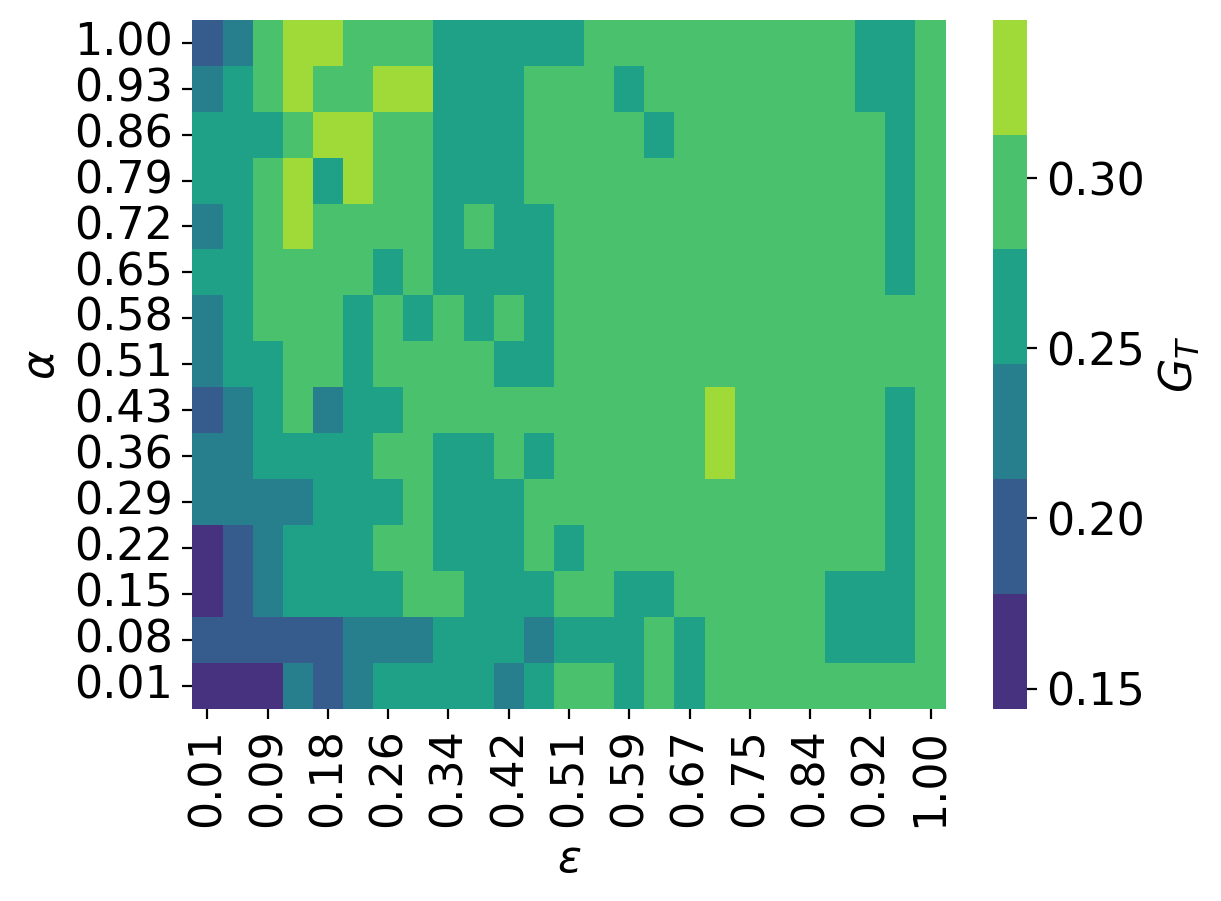

In [41]:
xsr_mean = pd.DataFrame(
    np.array(xsr.mean(axis=-1)),
    index=alpha_values, columns=epsilon_values
)

palette = sns.color_palette("viridis")

ax = sns.heatmap(
   xsr_mean,
    cmap=palette,
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
plt.savefig("../figures/non-stationary-alpha-epsilon-grid-sr.pdf", dpi=300);

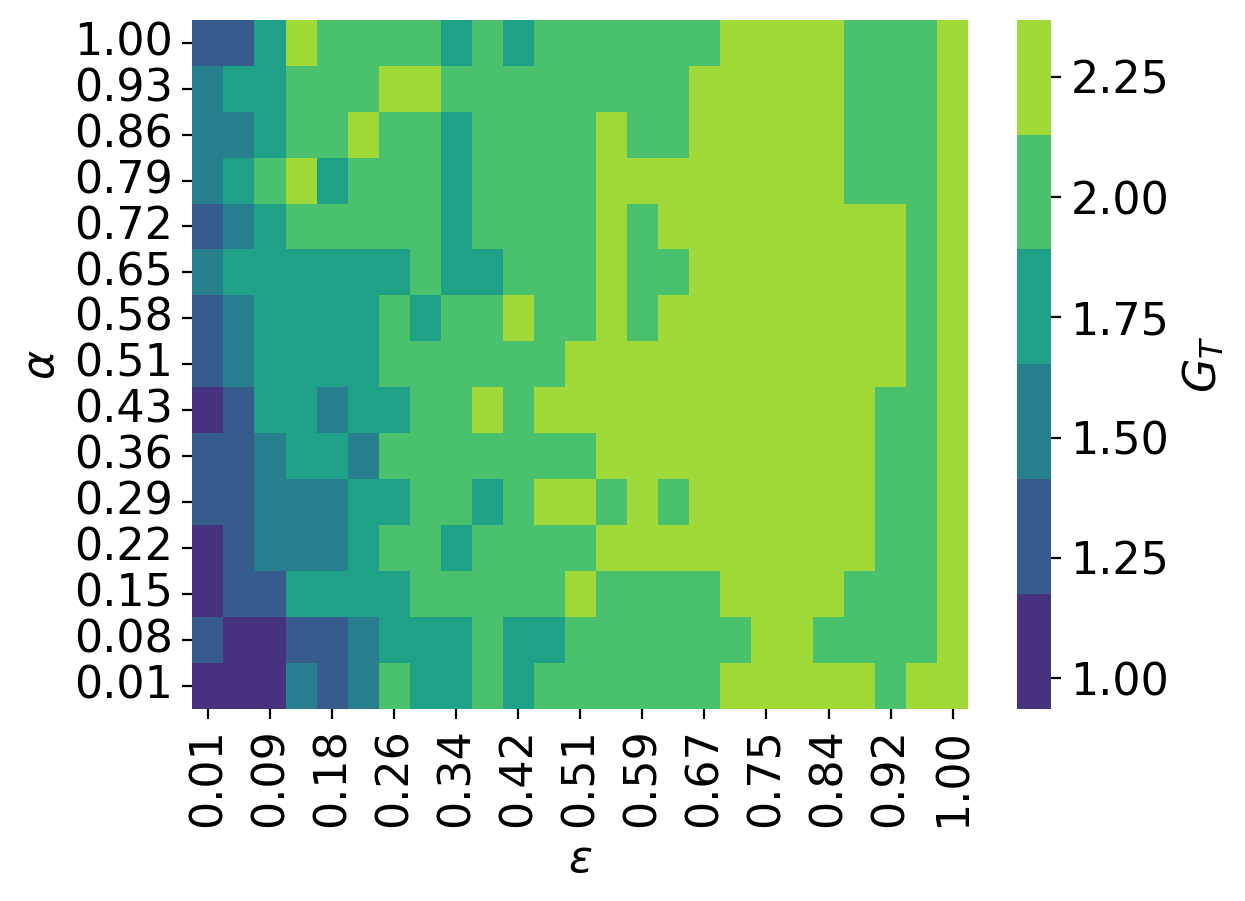

In [42]:
palette = sns.color_palette("viridis")

ax = sns.heatmap(
   xfinal_reward,
    cmap=palette,
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
plt.savefig("../figures/non-stationary-alpha-epsilon-grid.pdf", dpi=300);

## Tabular Contextual bandits

In [43]:
context = (returns > 0) * 1
context.shape

(6021, 6)

In [44]:
def contextual_epsilon_ewm_step(state, xs, epsilon, alpha):
    returns, context = xs
    context = tuple(context)
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value[context].argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    update_ix = tuple((*context, action))
    new_value = state.value[update_ix] + alpha * (reward - state.value[update_ix])
    
    state = state.replace(
        value=state.value.at[update_ix].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, (reward, action)

In [45]:
def returns_bandit(key, rewards, context, alpha, epsilon):
    _, n_arms = data.shape
    shape = (*(2,) * n_arms, n_arms)
    value_v = jnp.zeros(shape)
    state = BanditState(value=value_v, count=value_v, key=key)
    
    xs = (rewards, context)
    state_final, (returns_bandit, actions) = jax.lax.scan(partial(contextual_epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, xs)
    return returns_bandit, actions

In [46]:
res, actions = returns_bandit(key, returns[1:], context[:-1], alpha=0.5, epsilon=0.75)
actions_ohe = jax.nn.one_hot(actions, len(assets))

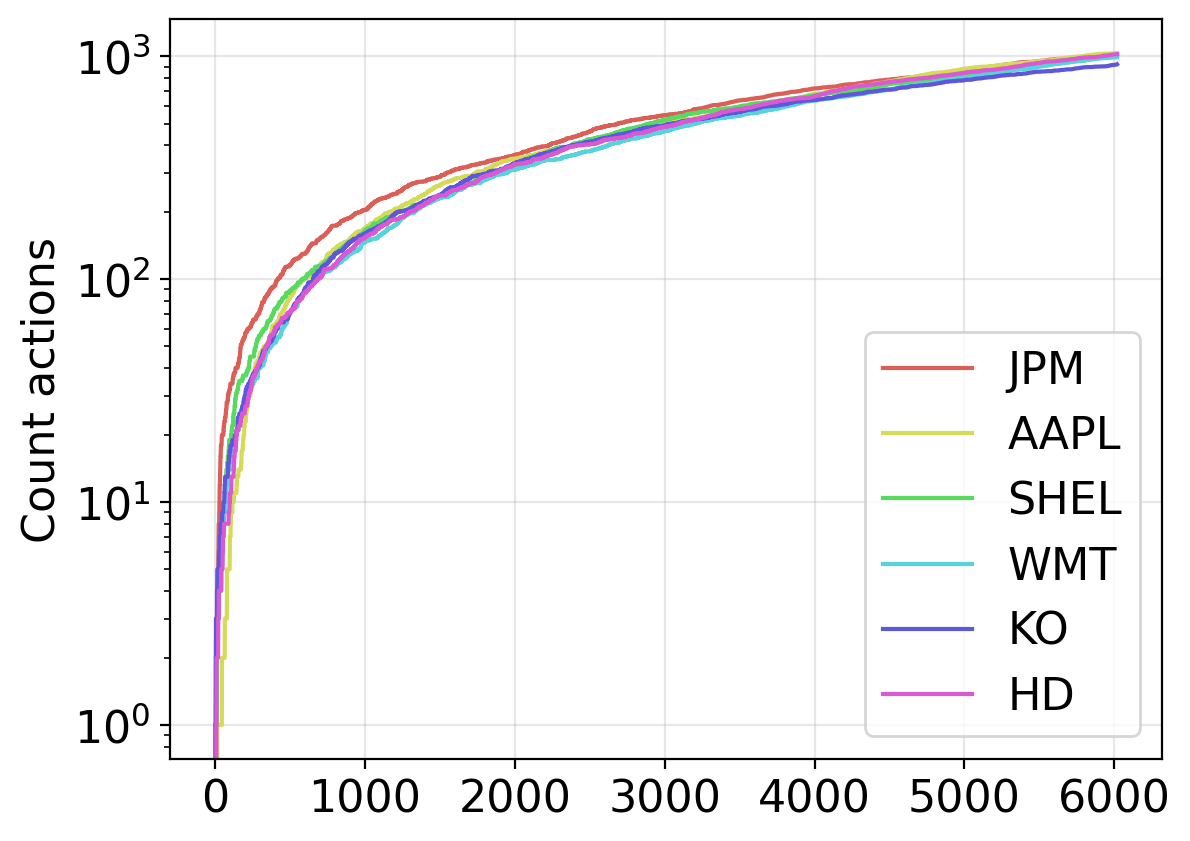

In [47]:
plt.plot(actions_ohe.cumsum(axis=0), label=assets)
plt.legend()
plt.ylabel("Count actions")
plt.yscale("log")
plt.grid(alpha=0.3)

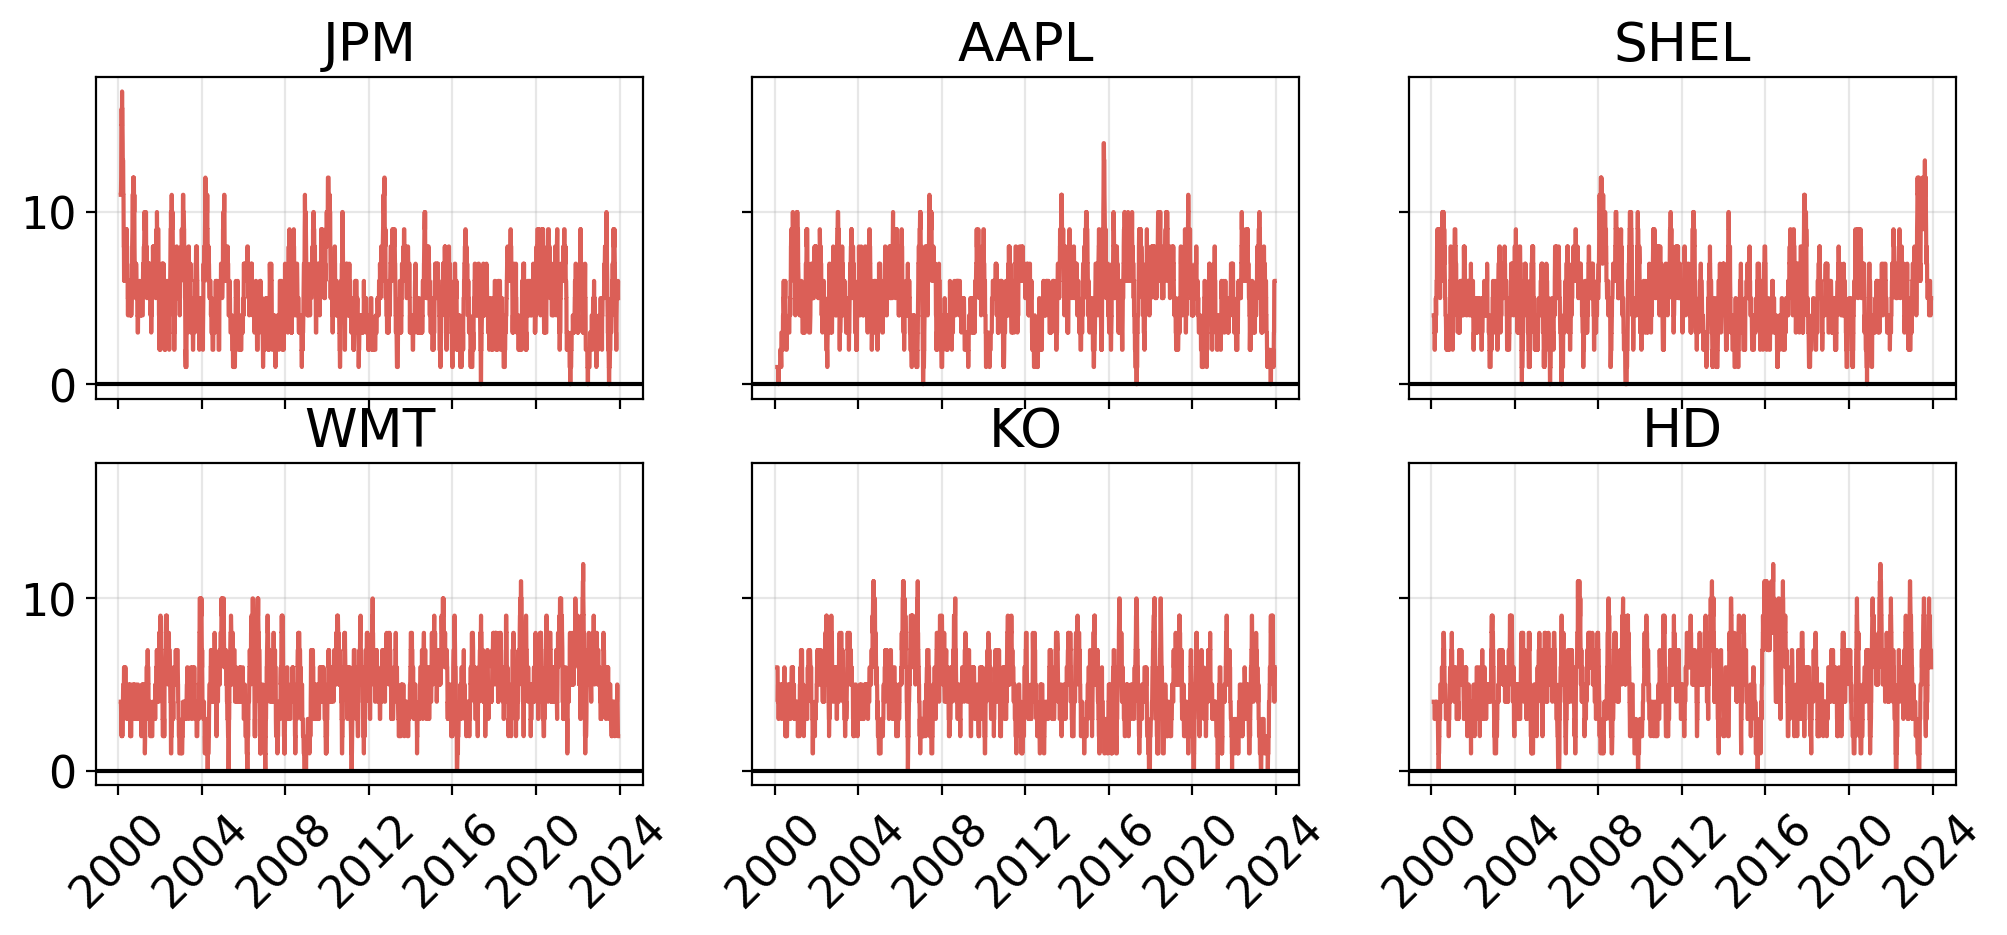

In [48]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 4.6))
ax = ax.ravel()
v = pd.DataFrame(actions_ohe, index=datasets.index[2:]).rolling(30).sum()
for i, axi in enumerate(ax):
    axi.set_title(assets[i])
    axi.plot(v[i])
    axi.axhline(y=0, c="black")
    axi.grid(alpha=0.3)
    plt.sca(axi)
    plt.xticks(rotation=45)

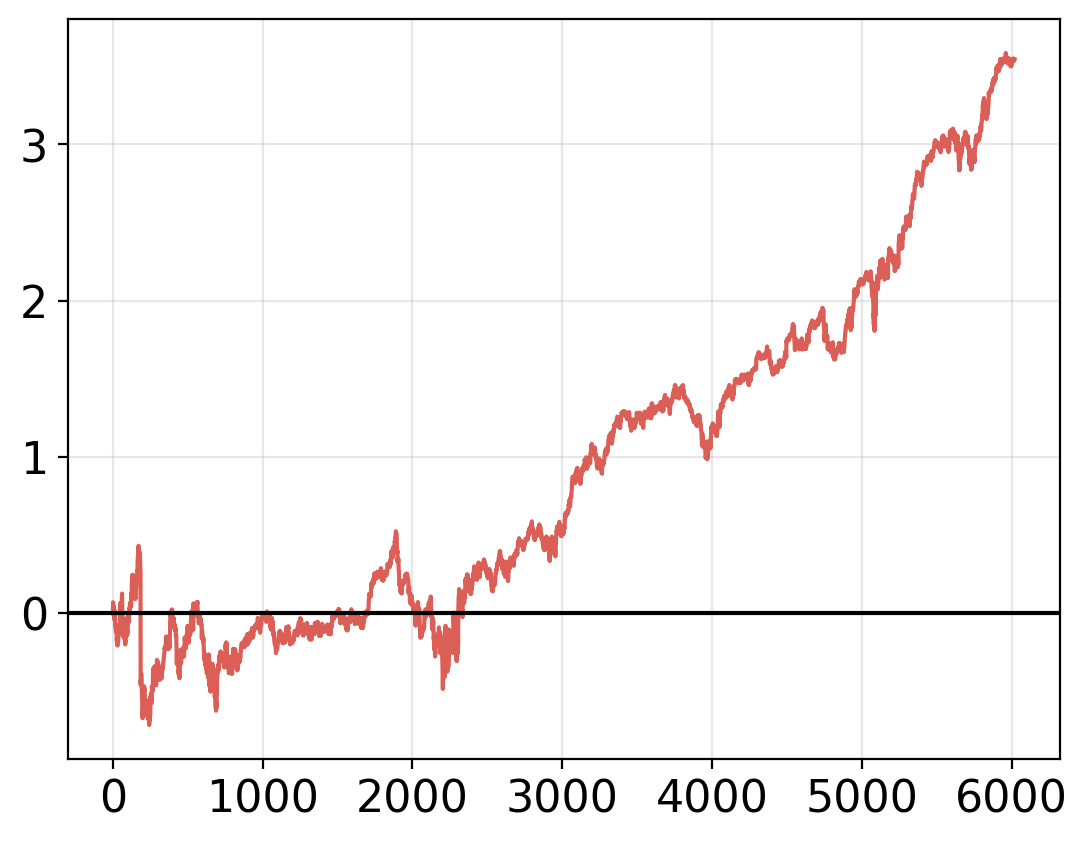

In [49]:
plt.plot(res.cumsum())
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")

In [50]:
sharpe_ratio = res.mean() / res.std() * np.sqrt(252)
sharpe_ratio

Array(0.42762104, dtype=float32)